In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Chevrolet.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop(df2[(df2["Fiyat"] > 700000)].index, axis=0, inplace=True)

In [4]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [5]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Aveo,Seri_Camaro,Seri_Caprice,...,Model_D LT,Model_LT,Model_RS,Model_Z06,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,305000,2011,100,1398,145000,1.0,0.0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,345000,2012,75,1248,181000,NaN,NaN,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2,355000,2011,94,1399,149500,0.0,0.0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,287000,2008,94,1391,153000,5.0,0.0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,238000,2004,94,1399,206000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [6]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [9]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [10]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_7040\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,39077.907798,1.410007e+09,37550.062767,28390.693798


In [11]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:07:39,476] A new study created in memory with name: no-name-e57b0a77-3bdc-4c42-9df0-d30692d96d91
[I 2023-10-08 14:07:39,639] Trial 0 finished with value: 355909.7412270161 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.000312166311973352, 'max_depth': 9, 'min_child_weight': 10}. Best is trial 0 with value: 355909.7412270161.
[I 2023-10-08 14:07:39,639] Trial 3 finished with value: 354671.5286871499 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.0006996696467176982, 'max_depth': 8, 'min_child_weight': 251}. Best is trial 3 with value: 354671.5286871499.
[I 2023-10-08 14:07:39,639] Trial 2 finished with value: 355351.8066014341 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0004756811253890082, 'max_depth': 13, 'min_child_weight': 121}. Best is trial 3 with value: 354671.5286871499.
[I 2023-10-08 14:07:39,639] Trial 1 finished with value: 33594.20178147229 and parameters: {'co

[I 2023-10-08 14:07:40,850] Trial 28 finished with value: 98181.63334904486 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.13135595156584762, 'max_depth': 11, 'min_child_weight': 55}. Best is trial 25 with value: 32906.23894950777.
[I 2023-10-08 14:07:40,876] Trial 30 finished with value: 158931.02134478063 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.08175801690255972, 'max_depth': 5, 'min_child_weight': 39}. Best is trial 25 with value: 32906.23894950777.
[I 2023-10-08 14:07:40,910] Trial 32 finished with value: 121175.91501120986 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.10918823640908032, 'max_depth': 11, 'min_child_weight': 44}. Best is trial 25 with value: 32906.23894950777.
[I 2023-10-08 14:07:40,967] Trial 33 finished with value: 117678.88611086163 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.11199752716825304, 'max_depth': 11, 'min_child_weig

[I 2023-10-08 14:07:42,674] Trial 60 finished with value: 65789.06865767247 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.17729364732845485, 'max_depth': 12, 'min_child_weight': 65}. Best is trial 52 with value: 32425.72280198827.
[I 2023-10-08 14:07:42,724] Trial 61 finished with value: 71481.70518964325 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.1723836616743838, 'max_depth': 12, 'min_child_weight': 25}. Best is trial 52 with value: 32425.72280198827.
[I 2023-10-08 14:07:42,773] Trial 62 finished with value: 82693.20776935459 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.151889322618701, 'max_depth': 12, 'min_child_weight': 29}. Best is trial 52 with value: 32425.72280198827.
[I 2023-10-08 14:07:42,839] Trial 64 finished with value: 67700.50537030815 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.1794839075452886, 'max_depth': 9, 'min_child_weight': 25

[I 2023-10-08 14:07:44,495] Trial 89 finished with value: 48709.55670474427 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.2180638563582606, 'max_depth': 15, 'min_child_weight': 35}. Best is trial 52 with value: 32425.72280198827.
[I 2023-10-08 14:07:44,606] Trial 91 finished with value: 45806.862972698844 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.22775957229739802, 'max_depth': 15, 'min_child_weight': 16}. Best is trial 52 with value: 32425.72280198827.
[I 2023-10-08 14:07:44,656] Trial 92 finished with value: 48477.84514749778 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.21510686747496072, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 52 with value: 32425.72280198827.
[I 2023-10-08 14:07:44,695] Trial 93 finished with value: 46782.88177119682 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.2210430966494639, 'max_depth': 15, 'min_child_weight':

[I 2023-10-08 14:07:46,568] Trial 120 finished with value: 32806.97941992969 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.49315996234485904, 'max_depth': 9, 'min_child_weight': 57}. Best is trial 100 with value: 32403.77746968819.
[I 2023-10-08 14:07:46,698] Trial 122 finished with value: 38763.49425613424 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3631954075091713, 'max_depth': 10, 'min_child_weight': 101}. Best is trial 100 with value: 32403.77746968819.
[I 2023-10-08 14:07:46,730] Trial 121 finished with value: 41356.43661348259 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3502823252290717, 'max_depth': 10, 'min_child_weight': 104}. Best is trial 100 with value: 32403.77746968819.
[I 2023-10-08 14:07:46,851] Trial 123 finished with value: 33736.43628632451 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.36207656124842064, 'max_depth': 10, 'min_child_

[I 2023-10-08 14:07:48,792] Trial 150 finished with value: 33820.84211694954 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.49794256828784506, 'max_depth': 9, 'min_child_weight': 81}. Best is trial 100 with value: 32403.77746968819.
[I 2023-10-08 14:07:48,891] Trial 151 finished with value: 33438.06587603578 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4296031503686465, 'max_depth': 9, 'min_child_weight': 92}. Best is trial 100 with value: 32403.77746968819.
[I 2023-10-08 14:07:49,011] Trial 152 finished with value: 32021.242184693496 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.48909188772932, 'max_depth': 9, 'min_child_weight': 22}. Best is trial 152 with value: 32021.242184693496.
[I 2023-10-08 14:07:49,097] Trial 153 finished with value: 32118.07131831746 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4934517137001262, 'max_depth': 10, 'min_child_weigh

[I 2023-10-08 14:07:51,324] Trial 180 finished with value: 35019.8071720377 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.392293457523425, 'max_depth': 10, 'min_child_weight': 5}. Best is trial 152 with value: 32021.242184693496.
[I 2023-10-08 14:07:51,436] Trial 181 finished with value: 32801.118462675615 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.39271247313259133, 'max_depth': 10, 'min_child_weight': 42}. Best is trial 152 with value: 32021.242184693496.
[I 2023-10-08 14:07:51,500] Trial 182 finished with value: 32805.2555527584 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.39175560415717164, 'max_depth': 10, 'min_child_weight': 42}. Best is trial 152 with value: 32021.242184693496.
[I 2023-10-08 14:07:51,604] Trial 183 finished with value: 32798.154897048975 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.37454086012563853, 'max_depth': 10, 'min_child

[I 2023-10-08 14:07:53,976] Trial 209 finished with value: 31841.699078773716 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.42819947826694693, 'max_depth': 9, 'min_child_weight': 28}. Best is trial 203 with value: 31824.0686236395.
[I 2023-10-08 14:07:54,072] Trial 211 finished with value: 153653.92661077724 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.08524017946789801, 'max_depth': 9, 'min_child_weight': 45}. Best is trial 203 with value: 31824.0686236395.
[I 2023-10-08 14:07:54,161] Trial 212 finished with value: 32664.625014898458 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4946237292414983, 'max_depth': 9, 'min_child_weight': 46}. Best is trial 203 with value: 31824.0686236395.
[I 2023-10-08 14:07:54,219] Trial 213 finished with value: 32511.56563921299 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3859776705327378, 'max_depth': 9, 'min_child_weigh

[I 2023-10-08 14:07:56,877] Trial 240 finished with value: 356344.45783080196 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0001871835614339653, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 215 with value: 31027.445381189646.
[I 2023-10-08 14:07:56,909] Trial 241 finished with value: 342046.3808149484 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.004403882990996291, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 215 with value: 31027.445381189646.
[I 2023-10-08 14:07:56,980] Trial 242 finished with value: 355704.88156761735 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.00037259975185041487, 'max_depth': 8, 'min_child_weight': 14}. Best is trial 215 with value: 31027.445381189646.
[I 2023-10-08 14:07:57,012] Trial 243 finished with value: 31828.535412436686 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.4183045058420106, 'max_depth': 8, 'mi

In [13]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 31027.4454
Best params:
	colsample_bytree: 1.0
	subsample: 0.6
	learning_rate: 0.49882050867481087
	max_depth: 9
	min_child_weight: 37


In [14]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 37682.270758185085, 'MSE': 1194160221.7361927, 'RMSE': 34556.62341340937, 'MAE': 27150.223146387834}


In [15]:
r2 = r2_score(y_test, y_pred)
r2

0.8298889691738032

In [16]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.80676400595162

In [17]:
marka_model = joblib.dump(final_model, "Chevrolet.pkl")

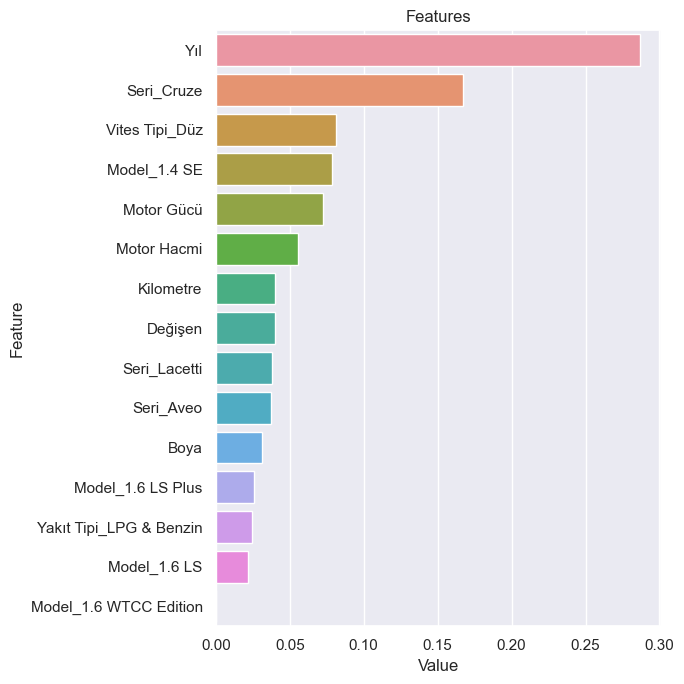

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)

In [19]:
y_test2 = list(y_test)

In [20]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [21]:
df3

,test,pred,fark
0,225000,216520.546875,-8479.453125
1,325000,331023.625000,6023.625000
2,198000,240074.640625,42074.640625
3,390000,393628.968750,3628.968750
4,225000,270077.281250,45077.281250
...,...,...,...
258,445500,465640.031250,20140.031250
259,425000,482712.062500,57712.062500
260,266000,254939.625000,-11060.375000
261,390000,337433.093750,-52566.906250


In [22]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,263.0,347020.452471,83944.508506,172250.000000,210499.000000,275000.000000,360000.0000,405000.000000,450000.00000,500000.000000,565500.00000
pred,263.0,342711.906250,79473.015625,190599.671875,210600.585938,274393.890625,359321.4375,402602.718750,443990.96875,489748.410000,516513.53125
fark,263.0,-4308.547172,34352.345671,-110568.687500,-60061.687500,-23717.218750,-4170.6875,18785.398438,36235.13750,72098.204375,110716.65625


In [23]:
df3["test"].max()

565500

In [24]:
df3[df3["test"]==975000]

,test,pred,fark


In [25]:
df3[df3["test"] > 600000]

,test,pred,fark


In [26]:
y_train2 = list(y_train)

In [27]:
for i in y_train2:
    if i > 600000:
        print(i)

610000
650000


In [28]:
df2.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
Fiyat,874.0,344237.717391,82718.982711,154000.0,215000.0,272250.0,355000.0,405000.0,450000.0,520810.0,650000.0
Yıl,874.0,2009.617849,2.749229,2004.0,2004.0,2008.0,2011.0,2012.0,2012.0,2013.0,2014.0
Motor Gücü,874.0,105.668192,20.481036,52.0,72.0,94.0,109.0,124.0,124.0,163.0,163.0
Motor Hacmi,874.0,1472.933638,192.036515,796.0,1150.0,1398.0,1598.0,1598.0,1598.0,1998.0,1998.0
Kilometre,874.0,176350.354691,63285.450603,25000.0,89325.0,131187.5,170000.0,211000.0,251000.0,354320.0,524000.0
...,...,...,...,...,...,...,...,...,...,...,...
Yakıt Tipi_Dizel,874.0,0.102975,0.304100,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Yakıt Tipi_LPG & Benzin,874.0,0.736842,0.440600,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
Vites Tipi_Düz,874.0,0.729977,0.444226,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
Vites Tipi_Otomatik,874.0,0.268879,0.443631,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
